# <span style='color:Blue'>Tyler/Sofrin Mode Calculator</span>

***

#### Background
* Tyler and Sofrin (1961) showed that rotor/stator interactions produce an infinite collection of spinning modes
* Each TS mode has an m-lobed pattern and rotates at a speed of BnΩ/m where:
        m = nB+kV (m is the Tyler/Sofrin mode number)
        n = impeller frequency harmonic
        k = vane harmonic
        B = # rotating blades
        V = # stationary vanes

* Example:
        8-blade rotor interacting with a 6-vane stator
        2-lobed pattern turning at (8)(1)/(2) = 4 times shaft speed

![Exampletable](ExampleTable.jpg)

![TSmode](TSmode.jpg)



#### Discrete Fourier Transform (DFT)
* To determine the pressure associated with each TS-mode, extend the simulation and compute the DFT of pressure @ desired blade passing frequency harmonics
* Disable (Hanning) windowing (for periodic flows such as this). Failure to do this will result in ½ expected magnitudes (for periodic flows)
    `(rpsetvar 'rtdft/window "none")`
* Ensure that sampling period corresponds to a multiple of the period of the lowest frequency. It can be a single period but it’s better to run for multiple periods (e.g. 1 revolution)
* The DFT data is only valid if sampling is performed across entire specified sampling period
* Nyquist criteria: Ensure that DFT sampling frequency is greater than 2*highest frequency

#### How this calculator works
* A circle of monitor points are created and  used to extract Fourier Coefficients (An and Bn)
* There should be at least 2*m monitor points to satisfy the (spatial) Nyquist Criteria
* The pressure associated with a particular TS mode (m) and BPF mode (n) is calculated as follows:

![TS_formulas](TS_formulas.jpg)

### Please note that the cas/dat file included with this notebook is for demonstration purposes. A finer mesh is required for proper acoustic analysis.

***


#### Launch Fluent

In [67]:
# This line is needed at the beginning of the notebook to allow for an interactive plot
%matplotlib widget
import ansys.fluent as pyfluent
session = pyfluent.launch_fluent()
session.check_health()

'SERVING'

#### User Inputs

The varnames should correspond to the variables writted from the DFT and can be determined by manually inspecting the solution variables as depicted below:
![Varnames](varnames.jpg)


In [74]:
n_mode = [0,1,2,3] # Impeller frequency harmonics
varname = ["static-pressure_0.00mHz-ta1" , "static-pressure_10.00kHz-ta2" , "static-pressure_20.00kHz-ta3" , "static-pressure_30.00kHz-ta4"] # Variable names from DFT analysis. Ensure len(n_mode)=len(varname)
r = 0.082 # meters
z = -0.037 # meters
dtheta = 5 # degrees
m_max = 50 # maximium TS mode number
m_inc = 2 # TS mode number increment. Plot will be from -m_max to +m_max, incremented by m_inc

#### CAS/DAT Files
The dat file should correspond to the already completed DFT simulation. 

In [69]:
session.tui.solver.file.read_case_data(case_file_name='axial_comp_fullWheel_DFT.cas') # The dat file containing the DFT results

<Future at 0x24691b26fc8 state=running>

#### Create Monitor Points

In [75]:
import math

for angle in range(0,360,dtheta):
    x = math.cos(math.radians(angle)) * r
    y = math.sin(math.radians(angle)) * r
    session.tui.solver.surface.point_surface('point-'+str(angle),x,y,z)  

#### Compute An and Bn at each monitor point

In [76]:
import numpy as np

An = np.zeros((len(varname),int(360/dtheta)))
Bn = np.zeros((len(varname),int(360/dtheta)))

for angle_ind, angle in enumerate(range(0,360,dtheta)): 
    for n_ind, variable in enumerate(varname):
        mag_string = session.scheme_eval.exec(('(ti-menu-load-string "/report/surface-int/vertex-max point-' +str(angle) + ' () ' + str(variable) + '-mag no")',))
        mag=eval(mag_string.split(' ')[-1])
        phase_string = session.scheme_eval.exec(('(ti-menu-load-string "/report/surface-int/vertex-max point-' +str(angle) + ' () ' + str(variable) + '-phase no")',))
        phase=eval(phase_string.split(' ')[-1])        
        An[n_ind][angle_ind]=mag*math.cos(phase)
        Bn[n_ind][angle_ind]=-mag*math.sin(phase)

#### Write Fourier Coefficients to File

This step is only required if data is to be processed outside of this script.

In [6]:
file1 = open("FourierCoefficients.txt", "w") 
file1.write("n theta An Bn \n")

for n_ind, variable in enumerate(varname):
    for ind,x in enumerate(An[n_ind,:]):
        file1.write(str(n_mode[n_ind]) + "," + str(ind*dtheta) + "," + str(An[n_ind,ind]) + "," + str(Bn[n_ind,ind])+"\n")


#### Calculating Pnm

![TS_formulas](TS_formulas.jpg)

In [77]:
# Create list of m values based on m_max and m_inc
m_mode = range(-m_max,m_max+m_inc,m_inc)

# Initialize solution matrices with zeros
Anm = np.zeros((len(varname),len(m_mode)))
Bnm = np.zeros((len(varname),len(m_mode)))
Pnm = np.zeros((len(varname),len(m_mode)))

for n_ind, variable in enumerate(varname): #loop over n modes
    for m_ind, m in enumerate(m_mode):     #loop over m modes
        for angle_ind, angle in enumerate(np.arange(0,math.radians(360),math.radians(dtheta))):  #loop over all angles, in radians
            Anm[n_ind][m_ind]+= An[n_ind][angle_ind] * math.cos(m*angle) - Bn[n_ind][angle_ind] * math.sin(m*angle)
            Bnm[n_ind][m_ind]+= An[n_ind][angle_ind] * math.sin(m*angle) + Bn[n_ind][angle_ind] * math.cos(m*angle)
        Anm[n_ind][m_ind] = Anm[n_ind][m_ind] / (2 * math.pi) * math.radians(dtheta)
        Bnm[n_ind][m_ind] = Bnm[n_ind][m_ind] / (2 * math.pi) * math.radians(dtheta)
        Pnm[n_ind][m_ind] = math.sqrt(Anm[n_ind][m_ind]**2 + Bnm[n_ind][m_ind]**2)

# P_00 is generally orders of magnitude larger than that of other modes. Giving focus to other modes by setting P_00 equal to zero
Pnm[0][int(len(m_mode)/2)]=0          

#### Tyler/Sofrin Mode Plot

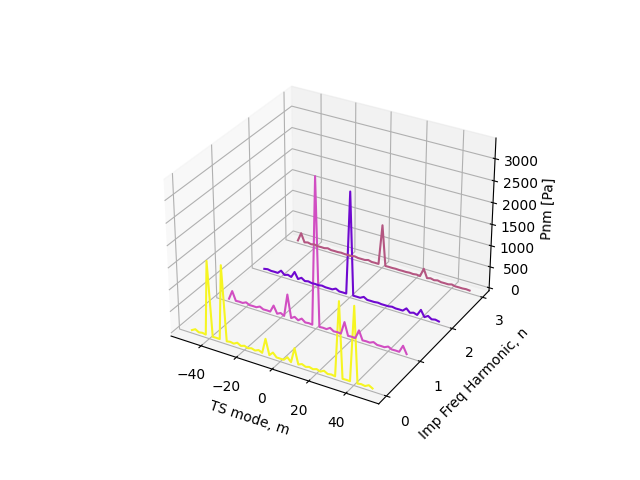

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('TS mode, m')
ax.set_ylabel('Imp Freq Harmonic, n')
ax.set_zlabel('Pnm [Pa]')
plt.yticks(n_mode)
for n_ind, n in enumerate(n_mode):
    x=m_mode
    y=np.full(Pnm.shape[1], n)
    z=Pnm[n_ind]
    rgb = (random.random(), random.random(), random.random())
    ax.plot3D(x, y, z, c=rgb)
